# Big Data Pararell Project

## Project made by Johannes Hägglund

The purpose of this project is to understand the concept and advantages with using Apache Spark when working with big amount of data. I will use the dataset containing handwritten digits <a href="http://yann.lecun.com/exdb/mnist/">MNIST</a> to build and deploy different Machine Learning models used for classification, such as Naive Bayes, K-nearest neighbors, Artificial Neural Network etc. During the deployment of machine learning models specific techniques for improving the models will be used, such as Hyperparameter tuning. 

Since the purpose of this project is to take advantage of Apache Spark, there will be an comparison with other libraries that dont use pararell computation so speed-up its computations. 

### Life cycle of Machine Learning

Often when working with project like this one, or Machine Learning projects generally, its very important to apply some steps before building models. I talk about data preprocessing which includes data gathering, data preperation and data cleaning.  

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import rand
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sn
from decimal import Decimal
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from time import time
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes as NaiveBayesPipe
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.util import MLUtils
import matplotlib.pyplot as plt


#from ProcessImageFolders import ImagesToCSV

## Data preprocessing and data analyzing
In this section I will preprocess the data before looking into Machine Learning models. The data will be gathered and structured such that it will be easy to manipulate, data will be cleaned on missing values, data augumentation and data standardization.



### Convert the images to CSV format
This step is only necessary if the files is still in different in folders and not structured and formated in CSV

In [2]:
#filename_test, filename_train = ('test', 'train')
#ImagesToCSV(filename_test, filename_train)

### Initiate SparkContext and SparkSession

In [3]:
spark = SparkSession \
    .builder \
    .appName("Spark Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
spark.conf.set('spark.sql.shuffle.partitions', 4)
spark.conf.set('spark.default.parallelism',4)
spark

### Load the data

In [4]:
start = time()
trainSet = spark.read.load("gs://bigdataproj_data0/train.csv",format="csv", sep=",", inferSchema="true", header="true")
train_load = time() - start
print("Time to load the training data: {} seconds".format(train_load))
print("Training count: {}".format(trainSet.count())

60000

In [5]:
start = time()
testSet = spark.read.load("gs://bigdataproj_data0/test.csv",format="csv", sep=",", inferSchema="true", header="true")
test_load = time() - start
print("Time to load the training data: {} seconds".format(test_load))
print("Training count: {}".format(testSet.count())

10000

### Show each unique label in the data

In [6]:
trainSet.select("label").distinct().show()

+-----+
|label|
+-----+
|    9|
|    6|
|    2|
|    4|
|    5|
|    3|
|    7|
|    8|
|    0|
|    1|
+-----+



In [7]:
testSet.select("label").distinct().show()

+-----+
|label|
+-----+
|    6|
|    9|
|    2|
|    4|
|    5|
|    0|
|    1|
|    7|
|    8|
|    3|
+-----+



### Count number of images per label in both training and test data

In [8]:
%matplotlib notebook
def plot_count_data(tr, te): # train, test
    
    query = tr.groupBy('label').count().orderBy('count', ascending=False).toPandas()
    labels = query['label']
    train_counts = query['count']
    
    query2 = te.groupBy('label').count().orderBy('count', ascending=False).toPandas()
    test_counts = query2['count']
    
    fig, ax = plt.subplots(2, 1)
    # ax[0]:
    ax[0].set_title("Train data")
    ax[0].bar(labels, train_counts)

    # ax[1]:
    ax[1].set_title("Test data")
    ax[1].bar(labels, test_counts)

    fig.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


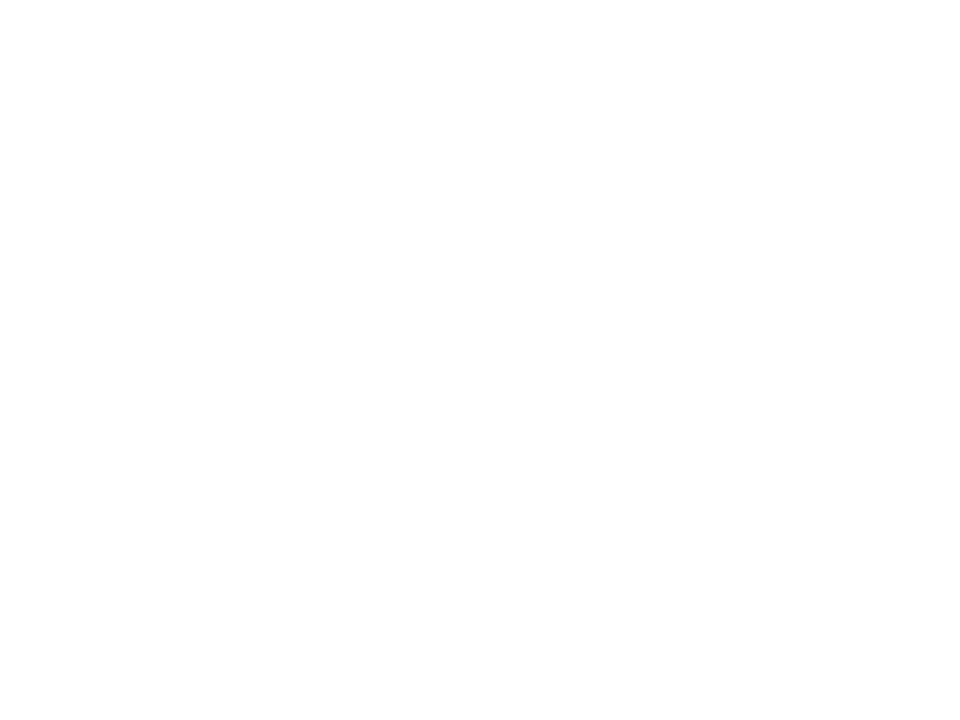

In [9]:
plot_count_data(trainSet, testSet)

### Visualize 100 digtis

<IPython.core.display.Javascript object>


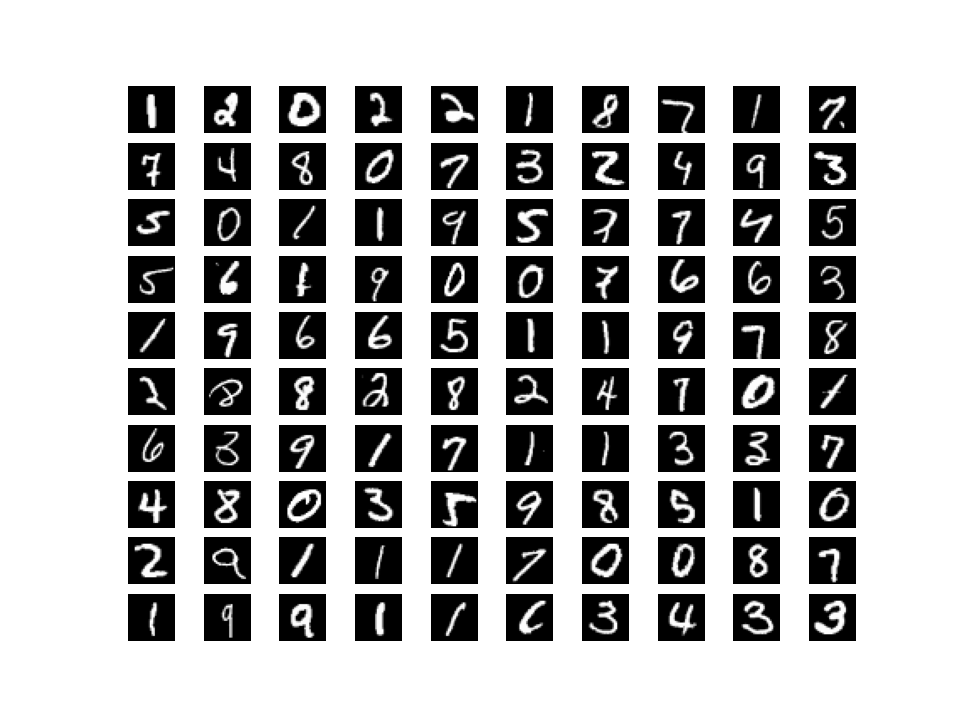

In [10]:
%matplotlib notebook
def display_digits(d):
    plt_rows = 10
    plt_cols = 10
    fig, ax = plt.subplots(plt_rows, plt_cols)
    
    n = plt_rows * plt_cols
    s = d.select([c for c in d.columns if c != 'label'])
    samples = s.orderBy(rand()).limit(n).rdd
    row_idx, col_idx = 0, 0
    for img in samples.collect():
        
        img_ = np.array(img).reshape(28,28)
        #print("rowidx: {}, colidx: {}".format(row_idx, col_idx))
        ax[row_idx][col_idx].imshow(img_, cmap='gray')
        ax[row_idx][col_idx].axis("off")
        
        col_idx += 1
        if col_idx == len(ax):
            row_idx += 1
            col_idx = 0
    
display_digits(trainSet)

## Prepare the data for ML model
Before building model it is important to prepare the data such that the model can be trained easily, this includes scaling, handle missing values, seperate feature data from label data etc. 

### Minimize the original dataset (due to the long wait when training the data)

In [11]:
'''
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
frac = 0.4
fractions_ = {}
for digit in digits:
    fractions_[digit] = frac
print(fractions_)   

#trainSet = trainSet.sampleBy('label', fractions=fractions_)
#trainSet.count()
#plot_count_data(trainSet, testSet)
#trainSet.groupBy('label').count().show()
'''

'\ndigits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]\nfrac = 0.4\nfractions_ = {}\nfor digit in digits:\n    fractions_[digit] = frac\nprint(fractions_)    \n'

### Vector Assembler
Now make use of the vector assembler to put all attributes into one vector, both for training and test data

In [15]:
newCols = [col for col in trainSet.columns if col != 'label']
print(newCols)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '15

#### Train data

In [16]:
trainAssembler = VectorAssembler(inputCols = newCols, outputCol='features')
trainAssembler_transformed = trainAssembler.transform(trainSet)
trainData = trainAssembler_transformed.select('features', 'label')
trainData.first()

Row(features=SparseVector(784, {127: 0.2, 128: 0.6235, 129: 0.9922, 130: 0.6235, 131: 0.1961, 154: 0.1882, 155: 0.9333, 156: 0.9882, 157: 0.9882, 158: 0.9882, 159: 0.9294, 181: 0.2118, 182: 0.8902, 183: 0.9922, 184: 0.9882, 185: 0.9373, 186: 0.9137, 187: 0.9882, 188: 0.2235, 189: 0.0235, 207: 0.0392, 208: 0.2353, 209: 0.8784, 210: 0.9882, 211: 0.9922, 212: 0.9882, 213: 0.7922, 214: 0.3294, 215: 0.9882, 216: 0.9922, 217: 0.4784, 235: 0.6392, 236: 0.9882, 237: 0.9882, 238: 0.9882, 239: 0.9922, 240: 0.9882, 241: 0.9882, 242: 0.3765, 243: 0.7412, 244: 0.9922, 245: 0.6549, 262: 0.2, 263: 0.9333, 264: 0.9922, 265: 0.9922, 266: 0.7451, 267: 0.4471, 268: 0.9922, 269: 0.8941, 270: 0.1843, 271: 0.3098, 272: 1.0, 273: 0.6588, 289: 0.1882, 290: 0.9333, 291: 0.9882, 292: 0.9882, 293: 0.702, 294: 0.0471, 295: 0.2941, 296: 0.4745, 297: 0.0824, 300: 0.9922, 301: 0.9529, 302: 0.1961, 316: 0.149, 317: 0.6471, 318: 0.9922, 319: 0.9137, 320: 0.8157, 321: 0.3294, 328: 0.9922, 329: 0.9882, 330: 0.6471, 343:

#### Test data

In [17]:
testAssembler = VectorAssembler(inputCols = newCols, outputCol='features')
testAssembler_transformed = testAssembler.transform(testSet)
testData = testAssembler_transformed.select('features', 'label')
testData.first()

Row(features=SparseVector(784, {123: 0.2392, 124: 0.0118, 125: 0.1647, 126: 0.4627, 127: 0.7569, 128: 0.4627, 129: 0.4627, 130: 0.2392, 149: 0.0549, 150: 0.702, 151: 0.9608, 152: 0.9255, 153: 0.949, 154: 0.9961, 155: 0.9961, 156: 0.9961, 157: 0.9961, 158: 0.9608, 159: 0.9216, 160: 0.3294, 177: 0.5922, 178: 0.9961, 179: 0.9961, 180: 0.9961, 181: 0.8353, 182: 0.7529, 183: 0.698, 184: 0.698, 185: 0.7059, 186: 0.9961, 187: 0.9961, 188: 0.9451, 189: 0.1804, 204: 0.1686, 205: 0.9216, 206: 0.9961, 207: 0.8863, 208: 0.251, 209: 0.1098, 210: 0.0471, 213: 0.0078, 214: 0.502, 215: 0.9882, 216: 1.0, 217: 0.6784, 218: 0.0667, 232: 0.2196, 233: 0.9961, 234: 0.9922, 235: 0.4196, 243: 0.5255, 244: 0.9804, 245: 0.9961, 246: 0.2941, 260: 0.2471, 261: 0.9961, 262: 0.6196, 272: 0.8667, 273: 0.9961, 274: 0.6157, 288: 0.7608, 289: 0.9961, 290: 0.4039, 300: 0.5882, 301: 0.9961, 302: 0.8353, 315: 0.1333, 316: 0.8627, 317: 0.9373, 318: 0.2275, 328: 0.3294, 329: 0.9961, 330: 0.8353, 343: 0.4941, 344: 0.9961, 34

## Build models
Now when the data is structured and prepared it is ready for model training. For this task we will examine more than one machine learning algorithm (classification algorithms). The algorithms that will be examined are:
* Naive Bayes
* Logistic Regression
* Random Forest
* Multilayer Perceptron Neural Network

The models will be builded twice, first with MLlib Pipelines and then with MLlib RDDs which will be compared with each other in computation time and performance.

### Display predictions
The raw data that comes with the predictions for each model can be a bit messy to interpret, therefore a function that can display predictions with correct labels using confusion matrix concept will be implemented below. 
Pyspark comes with a library MutlticlassMetrics that can be used to create an confusionMatrix of given data, and with the use of seaborn it can be displayed within a figure.

In [18]:
def display_confusion_matrix(predictions, title): # result should be the result of the prediction
    predictions = (predictions
    .withColumn("label", predictions["label"].cast("double")))
    preds_and_labels = predictions.select('prediction', 'label').rdd
    confus_metric = MulticlassMetrics(preds_and_labels.map(tuple)).confusionMatrix().toArray()
    
    plt.figure(figsize=(10, 5))
    sn.heatmap(confus_metric, annot=True)
    plt.xlabel("Predicted label") 
    plt.ylabel("True label")
    plt.title(title)
    plt.show()

### Evaluator
The evaluator will be of multiclass-evaluation and is a pyspark object that will be used to evaluate the model predictions, all models will use the same evaluator therefore this can be initilized before. 

In [19]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName="accuracy")

## MLlib Pipeline

### Naive Bayes
#### Initate the pipeline with model

In [20]:
nb = NaiveBayesPipe(modelType="multinomial", smoothing=1)
nbPipeline = Pipeline(stages=[nb])

#### Train, test and evaluate model

In [21]:
start = time()
nbpipemodel = nbPipeline.fit(trainData)
predictions = nbpipemodel.transform(testData)
acc_nb = evaluator.evaluate(predictions)
naiveb_time = time() - start
print("Time to train, test and evaluate Naive Bayes classifier using Spark Pipeline: {} seconds".format(naiveb_time))
print("Accuracy: {} %".format(acc_nb*100))

Time to train, test and evaluate Naive Bayes classifier using Spark Pipeline: 9.77683687210083 seconds
Accuracy: 83.57 %


#### Model improvement

In [22]:
start = time()
regparams = np.linspace(0, 3, 11)
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, regparams).build()
crossval = CrossValidator(estimator=nbPipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvmodel_nb = crossval.fit(trainData)
pred_nb_tuned = cvmodel_nb.transform(testData)
acc_nb_improved = evaluator.evaluate(pred_nb_tuned)
naiveb_tuning_time = time() - start

It took 53.86874485015869 seconds to tune the Naive Bayes model with 11 number of params
The tuned model gave smoothing 0.3 with an accuracy 83.59 %


<IPython.core.display.Javascript object>


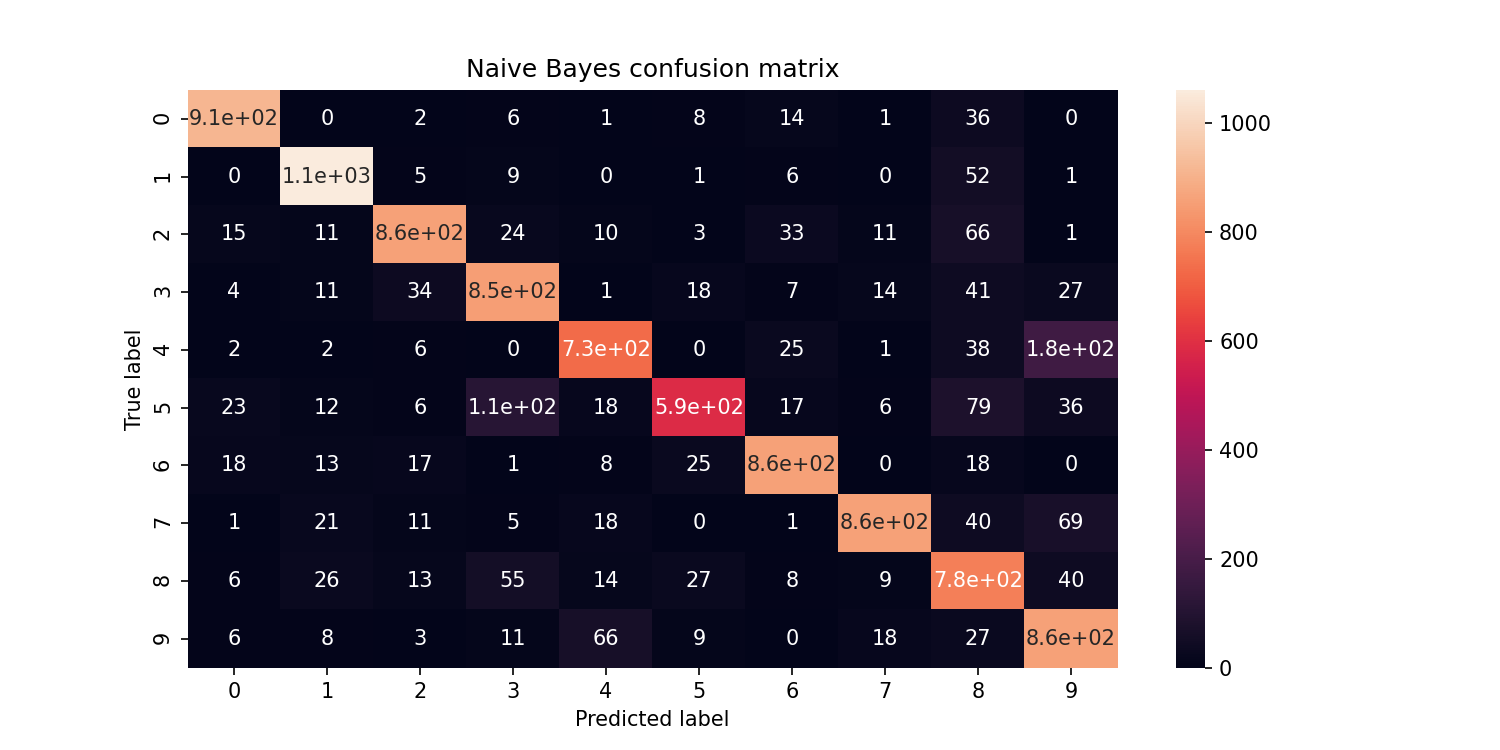

In [23]:
best_param_nb = cvmodel_nb.bestModel.stages[0].getSmoothing()
print("It took {} seconds to tune the Naive Bayes model with {} number of params".format(naiveb_tuning_time, len(regparams)))
print("The tuned model gave smoothing {} with an accuracy {} %".format(best_param_nb, acc_nb_improved*100))
display_confusion_matrix(pred_nb_tuned, "Naive Bayes confusion matrix")

#### Run the model with the new param

In [24]:
nb.setSmoothing(best_param_nb)

NaiveBayes_4a8ac949d640

In [25]:
start = time()
nbpipemodel = nbPipeline.fit(trainData)
predictions = nbpipemodel.transform(testData)
acc_nb_bestm = evaluator.evaluate(predictions)
naiveb_time_bestm = time() - start
print("Time to train, test and evaluate Naive Bayes classifier using Spark Pipeline: {} seconds".format(naiveb_time_bestm))
print("Accuracy: {} %".format(acc_nb_bestm*100))

Time to train, test and evaluate Naive Bayes classifier using Spark Pipeline: 4.588022232055664 seconds
Accuracy: 83.59 %


### Logistic Regression
#### Initiate the Pipeline

In [26]:
lr = LogisticRegression(maxIter=10, regParam=0, elasticNetParam=0, family='multinomial')
lrPipeline = Pipeline(stages=[lr])

#### Train, test and evaluate the model

In [27]:
start = time()
lrPipemodel= lrPipeline.fit(trainData)
preds = lrPipemodel.transform(testData)
lr_accuracy = round(evaluator.evaluate(preds), 2)
logistic_time = time() - start
print("Time taken to train, test and evaluate logistic regression pipeline: {} seconds".format(logistic_time))
print("Accuracy: {} %".format(lr_accuracy*100))

Time taken to train, test and evaluate logistic regression pipeline: 11.266943454742432 seconds
Accuracy: 90.0 %


#### Model improvement

In [28]:
reg = [0, 0.05, 0.08, 0.1, 0.3] # lambda
maxiter = [10] # maxiter

start = time()
paramGrid = ParamGridBuilder().addGrid(lr.regParam, reg).addGrid(lr.maxIter, maxiter).build()

crossval = CrossValidator(estimator=lrPipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvmodel_lr = crossval.fit(trainData)
lr_pred_tuned = cvmodel_lr.transform(testData)
acc_lr_tuned = round(evaluator.evaluate(lr_pred_tuned), 2)
logistic_tuning_time = time() - start

The tuning is selecting the best params in regparameter and max iterations
For the regParam it will try out 5 different values
For the max iteration it will try out 1 different values
It took 67.2640540599823 seconds to tune the Logistic model
The best combination of parameters is regParam:0.0, maxiter:10, which got 90.0 % in accuracy


<IPython.core.display.Javascript object>


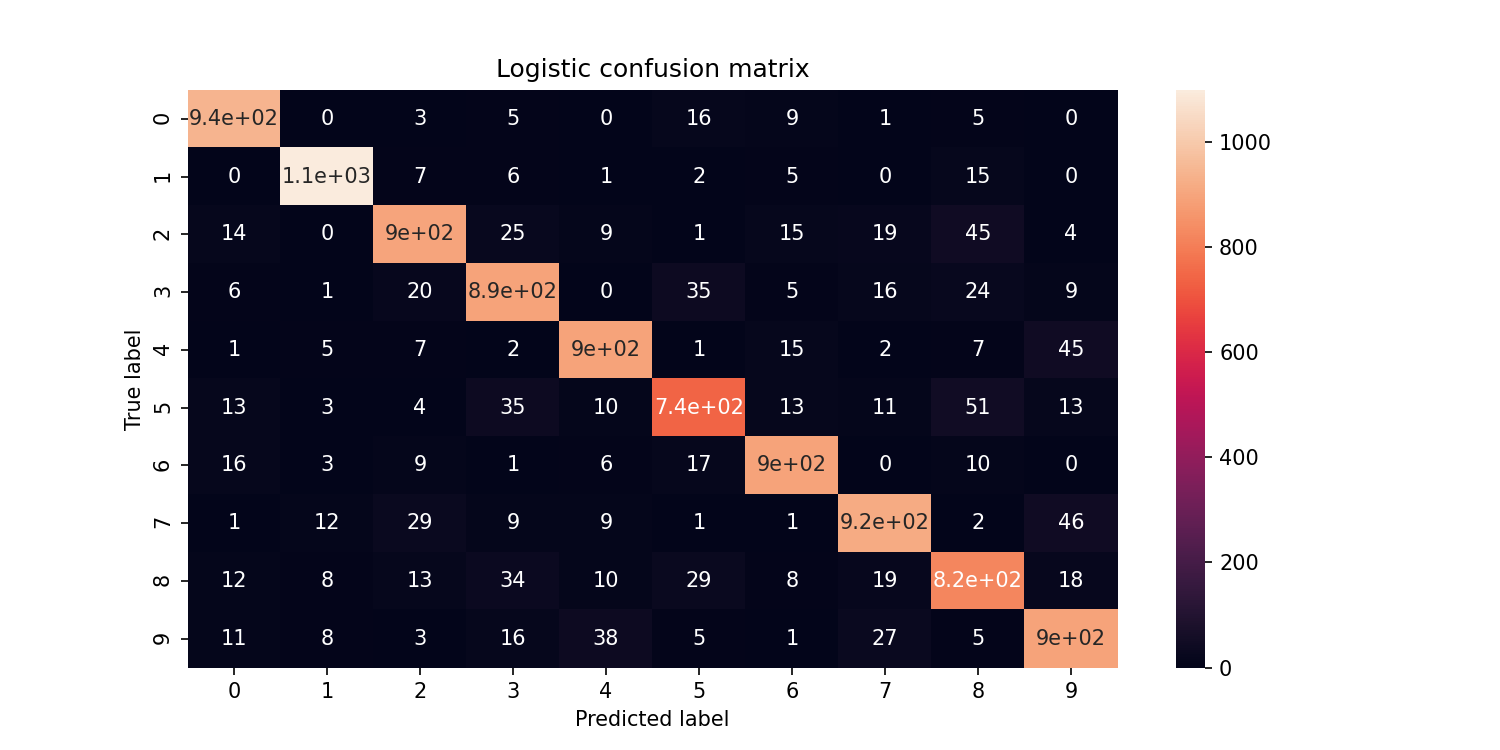

In [29]:
best_model_lr = cvmodel_lr.bestModel.stages[0]
best_maxitr_lr = best_model_lr.getMaxIter()
best_regparam_lr = best_model_lr.getRegParam()

print("The tuning is selecting the best params in regparameter and max iterations")
print("For the regParam it will try out {} different values".format(len(reg)))
print("For the max iteration it will try out {} different values".format(len(maxiter)))
print("It took {} seconds to tune the Logistic model".format(logistic_tuning_time))     
print("The best combination of parameters is regParam:{}, maxiter:{}, which got {} % in accuracy".format(best_regparam_lr, best_maxitr_lr, acc_lr_tuned*100))   
display_confusion_matrix(lr_pred_tuned, "Logistic confusion matrix")

#### Run the new model

In [30]:
lr.setMaxIter(best_maxitr_lr)
lr.setRegParam(best_regparam_lr)

LogisticRegression_ddcf451ad37c

In [31]:
start = time()
lrPipemodel = lrPipeline.fit(trainData)
preds = lrPipemodel.transform(testData)
lr_accuracy_bestm = round(evaluator.evaluate(preds), 2)
logistic_time_bestm = time() - start
print("Time taken to train, test and evaluate logistic regression pipeline: {} seconds".format(logistic_time_bestm))
print("Accuracy: {} %".format(lr_accuracy_bestm*100))

Time taken to train, test and evaluate logistic regression pipeline: 9.699292421340942 seconds
Accuracy: 90.0 %


### Random Forest
#### Initiate the pipeline

In [32]:
rf = RandomForestClassifier(numTrees=5)
rfPipeline = Pipeline(stages=[rf])

#### Train, test and evaluate the model

In [33]:
start = time()
rfPipelinemodel = rfPipeline.fit(trainData)
rf_preds = rfPipelinemodel.transform(testData)
acc_rf = round(evaluator.evaluate(rf_preds), 2)
rf_time = time() - start

In [34]:
print("Time to train, test and evaluate Random Forest classifier: {} seconds, with accuracy = {} %".format(rf_time, acc_rf*100))

Time to train, test and evaluate Random Forest classifier: 15.086261987686157 seconds, with accuracy = 77.0 %


#### Model improvement

In [35]:
numoftrees = [5, 100] #numoftrees
maxDepth_ = [5, 8] # maxdepth
start = time()
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, numoftrees).addGrid(rf.maxDepth, maxDepth_).build()
crossval = CrossValidator(estimator=rfPipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvmodel_rf = crossval.fit(trainData)
pred_rf_tuned = cvmodel_rf.transform(testData)
acc_rf_tuned = evaluator.evaluate(pred_rf_tuned)
rf_tuned_time = time() - start

The tuning is done by selecting the best number of trees and max depth
For the number of trees it will try 2 different values
For the max depth it will try 2 different values
It took 187.66881775856018 seconds to tune the Random Forest
The best combination of parameters is number of trees:100, maxdepth:8, which got 92.75 % accuracy


<IPython.core.display.Javascript object>


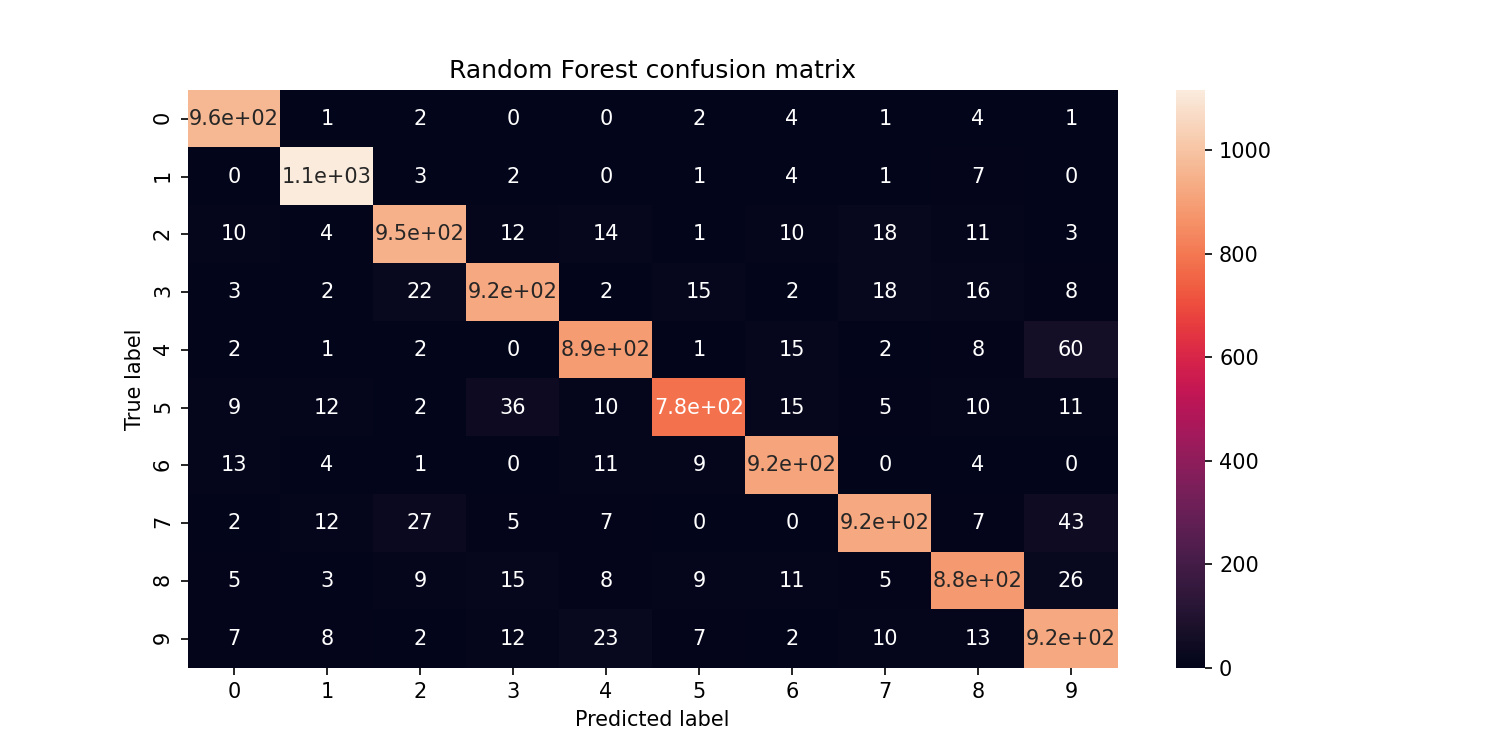

In [36]:
best_modelrf = cvmodel_rf.bestModel.stages[0]

best_numoftrees_rf = best_modelrf.getNumTrees
best_maxdepth_rf = best_modelrf.getMaxDepth()

print("The tuning is done by selecting the best number of trees and max depth")
print("For the number of trees it will try {} different values".format(len(numoftrees)))
print("For the max depth it will try {} different values".format(len(maxDepth_)))
print("It took {} seconds to tune the Random Forest".format(rf_tuned_time))     
print("The best combination of parameters is number of trees:{}, maxdepth:{}, which got {} % accuracy".format(best_numoftrees_rf, best_maxdepth_rf, acc_rf_tuned*100))
display_confusion_matrix(pred_rf_tuned, "Random Forest confusion matrix")

#### Run the new model

In [37]:
rf.setMaxDepth(best_maxdepth_rf)
rf.setNumTrees(best_numoftrees_rf)

RandomForestClassifier_e2734b4c98c6

In [38]:
start = time()
rfPipelinemodel = rfPipeline.fit(trainData)
rf_preds = rfPipelinemodel.transform(testData)
acc_rf_bestm = evaluator.evaluate(rf_preds)
rf_time_bestm = time() - start
print("Time taken to train, test and evaluate Random Forest pipeline: {} seconds".format(rf_time_bestm))
print("Accuracy: {} %".format(acc_rf_bestm*100))

Time taken to train, test and evaluate Random Forest pipeline: 40.179606437683105 seconds
Accuracy: 92.75 %


### Multilayer perceptron neural network

#### Initiate the pipeline

In [39]:
layers = [784, 4, 10]
MLP = MultilayerPerceptronClassifier(maxIter=100, layers=layers)
mlpPipeline = Pipeline(stages=[MLP])

#### Train, test and evaluate the model

In [40]:
start = time()
MLPpreds = mlpPipeline.fit(trainData).transform(testData)
mlp_acc = evaluator.evaluate(MLPpreds)
mlp_time = time() - start

In [41]:
print("MLP neural network got {} % in accuracy and took {} seconds to train, predict and evaluate".format(mlp_acc*100, mlp_time))

MLP neural network got 84.28999999999999 % in accuracy and took 30.957048892974854 seconds to train, predict and evaluate


#### Model improvment

In [42]:
layers = [[784, 4, 10], 
          [784, 100, 10]]
maxiter_ = [100]
start = time()
paramGrid = ParamGridBuilder().addGrid(MLP.layers, layers).addGrid(MLP.maxIter, maxiter_).build()
crossval = CrossValidator(estimator=mlpPipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvmodel_mlp = crossval.fit(trainData)
pred_mlp_tuned = cvmodel_mlp.transform(testData)
acc_MLP_tuned = evaluator.evaluate(pred_mlp_tuned)
MLP_tuned_time = time() - start

Best max iteration: 100
Best layer combination: [784, 100, 10]
Tuned Accuracy: 97.06 %
Time taken to tune: 396.91896772384644 seconds


<IPython.core.display.Javascript object>


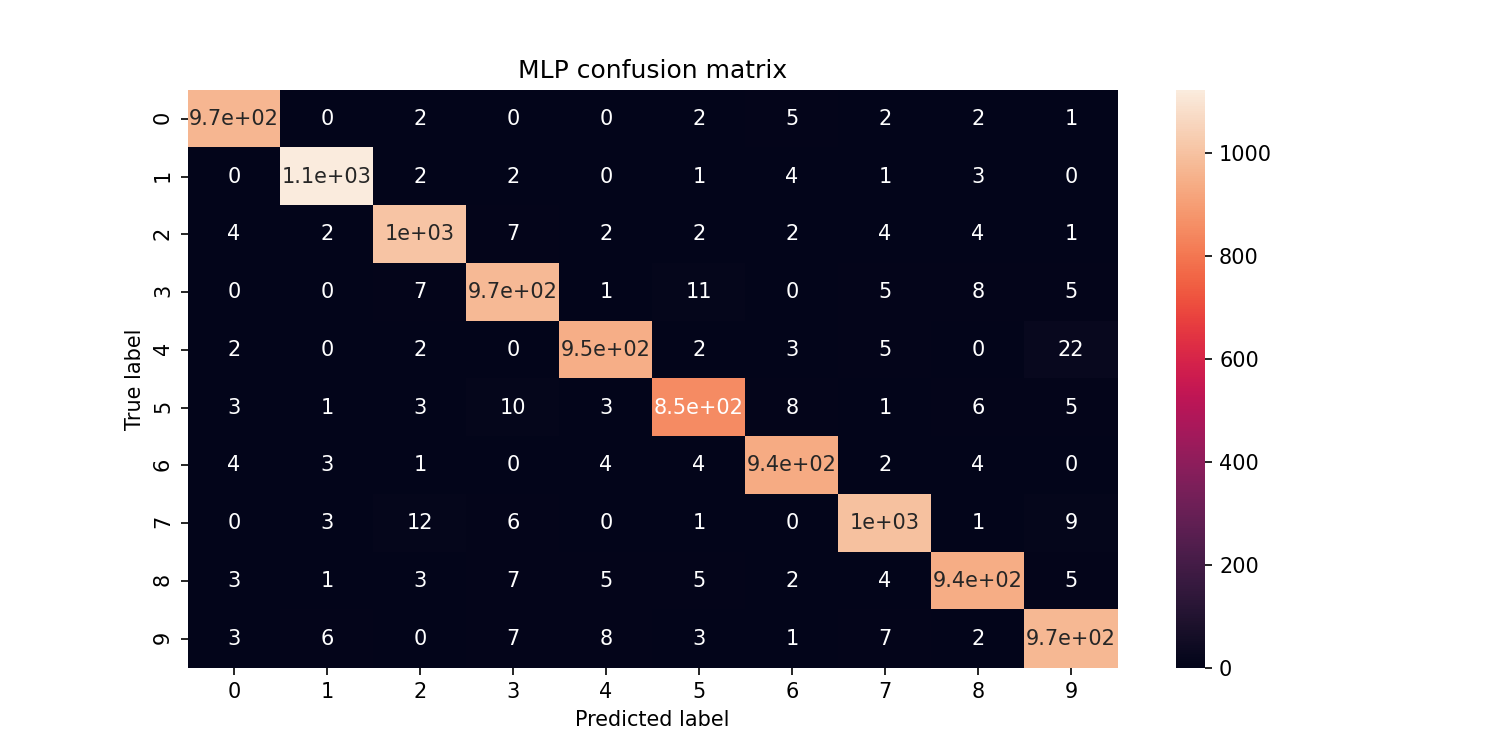

In [43]:
best_model_mlp = cvmodel_mlp.bestModel.stages[0]
best_layer_mlp = best_model_mlp.getLayers()
best_maxiter_mlp = best_model_mlp.getMaxIter()

print("Best max iteration: {}".format(best_maxiter_mlp))
print("Best layer combination: {}".format(best_layer_mlp))
print("Tuned Accuracy: {} %".format(acc_MLP_tuned*100))
print("Time taken to tune: {} seconds".format(MLP_tuned_time))
display_confusion_matrix(pred_mlp_tuned, "MLP confusion matrix")

#### Run the new model

In [44]:
MLP.setLayers(best_layer_mlp)
MLP.setMaxIter(best_maxiter_mlp)

MultilayerPerceptronClassifier_101b60d10ba4

In [45]:
start = time()
MLPpreds = mlpPipeline.fit(trainData).transform(testData)
mlp_acc_bestm = evaluator.evaluate(MLPpreds)
mlp_time_bestm = time() - start
print("Best accuracy for MLP {} %".format(mlp_acc_bestm*100))
print("Time taken: {} seconds".format(mlp_time_bestm))

Best accuracy for MLP 97.06 %
Time taken: 107.66264247894287 seconds


## MLlib with RDD

The same training will be done as above but in this section I will train, transform and predict using RDD solution.
RDD stands for Resiliten Distributed Dataset and is a data structure within spark which can be said to be a collection of immutable distributed collection of objects. 


The purpose with RDDs is that dividing the data into a number of partitions which then can be distributed to different worker nodes in the system, and in that case achive parallelism which could speed up the computations.  

The number of partitions can either be default = 2 or it can be specified by the developer (4, 5, 6, 8). To repartition RDDs it comes with two different functions:
* coalesce - which can be used to reduce the amount of partitions. 
* repartition - can be used to either increase or decrease the number of partitions



First lets print how many partitions the data is divided into right now.

In [46]:
def convertToLabeledPoint(data):
    labeled_rdd = data.rdd.map(lambda row: LabeledPoint(row['label'], row['features'].toArray()))
    return labeled_rdd

### Prepare data for RDD 

In [47]:
trainDataLBPoint = convertToLabeledPoint(trainData)
testDataLBPoint = convertToLabeledPoint(testData)

In [48]:
trainDataLBPoint.first()

LabeledPoint(0.0, [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.62352943,0.99215686,0.62352943,0.19607843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1882353,0.93333334,0.9882353,0.9882353,0.9882353,0.92941177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21176471,0.8901961,0.99215686,0.9882353,0.9372549,0.9137255,0.9882353,0.22352941,0.023529412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039215688,0.23529412,0.878

In [49]:
testDataLBPoint.first()

LabeledPoint(0.0, [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.23921569,0.011764706,0.16470589,0.4627451,0.75686276,0.4627451,0.4627451,0.23921569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05490196,0.7019608,0.9607843,0.9254902,0.9490196,0.99607843,0.99607843,0.99607843,0.99607843,0.9607843,0.92156863,0.32941177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5921569,0.99607843,0.99607843,0.99607843,0.8352941,0.7529412,0.69803923,0.69803923,0.7058824,0.99607843,0.99607843,0.94509804,0.18039216,0

In [50]:
trainDataLBPoint.getNumPartitions()

4

In [51]:
traind = trainDataLBPoint.repartition(100)

In [52]:
testd = testDataLBPoint.repartition(100)

In [53]:
traind.getNumPartitions()

100

### Naive Bayes

#### Train, test and evaluate model

In [54]:
def NB(partition):
    if partition > traind.getNumPartitions():
        return None
    traindata = traind.coalesce(partition)
    testdata = testd.coalesce(partition)
    start = time()
    nb_modelrdd = NaiveBayes.train(traindata, best_param_nb) 
    predictionAndLabel = testdata.map(lambda p: (nb_modelrdd.predict(p.features), p.label))
    acc_nb_rdd = 100 * predictionAndLabel.filter(lambda pl: pl[0] == pl[1]).count() / testdata.count()
    rdd_nb_time = time() - start
    return rdd_nb_time, acc_nb_rdd

In [55]:
# 2 partitions:
time0, acc0 = NB(2)
# 4 partitions:
time1, acc1 = NB(4)
# 6 partitions:
time2, acc2 = NB(6)
# 8 partitions:
time3, acc3 = NB(8)
# 15 partitions:
time4, acc4 = NB(15)
# 25 partitions
time5, acc5 = NB(25)
# 50 partitions
time6, acc6 = NB(50)

In [56]:
print("Time taken to train, test and evaluate with 2 partitions, {} seconds and gave {} % accuracy".format(time0, acc0))
print("Time taken to train, test and evaluate with 4 partitions, {} seconds and gave {} % accuracy".format(time1, acc1))
print("Time taken to train, test and evaluate with 6 partitions, {} seconds and gave {} % accuracy".format(time2, acc2))
print("Time taken to train, test and evaluate with 8 partitions, {} seconds and gave {} % accuracy".format(time3, acc3))
print("Time taken to train, test and evaluate with 15 partitions, {} seconds and gave {} % accuracy".format(time4, acc4))
print("Time taken to train, test and evaluate with 25 partitions, {} seconds and gave {} % accuracy".format(time5, acc5))
print("Time taken to train, test and evaluate with 50 partitions, {} seconds and gave {} % accuracy".format(time6, acc6))

Time taken to train, test and evaluate with 2 partitions, 11.591922760009766 seconds and gave 83.59 % accuracy
Time taken to train, test and evaluate with 4 partitions, 3.0722594261169434 seconds and gave 83.59 % accuracy
Time taken to train, test and evaluate with 6 partitions, 2.768667697906494 seconds and gave 83.59 % accuracy
Time taken to train, test and evaluate with 8 partitions, 2.5151679515838623 seconds and gave 83.59 % accuracy
Time taken to train, test and evaluate with 15 partitions, 2.277909994125366 seconds and gave 83.59 % accuracy
Time taken to train, test and evaluate with 25 partitions, 2.3705570697784424 seconds and gave 83.59 % accuracy
Time taken to train, test and evaluate with 50 partitions, 3.1770808696746826 seconds and gave 83.59 % accuracy


### Logistic Regression

#### Train, test and evaluate model

In [57]:
def LR(partition):
    if partition > traind.getNumPartitions():
        return None
    traindata = traind.coalesce(partition)
    testdata = testd.coalesce(partition)
    start = time()

    lrmodelrdd = LogisticRegressionWithLBFGS.train(traindata, iterations=best_maxitr_lr, regParam=best_regparam_lr, numClasses=10) # #best_maxitr_lr, best_regparam_lr
    prediction = testdata.map(lambda x: (lrmodelrdd.predict(x.features), x.label))
    acc = 100 *((prediction.filter(lambda pred: pred[0] == pred[1]).count()) / testdata.count())
    lr_rdd_time = time() - start
    
    return lr_rdd_time, acc

In [58]:
# 2 partitions:
lr_time0, lr_acc0 = LR(2)
print("2 done")
# 4 partitions:
lr_time1, lr_acc1 = LR(4)
print("4 partitions done")
# 6 partitions:
lr_time2, lr_acc2 = LR(6)
print("6 partitions done")
# 8 partitions:
lr_time3, lr_acc3 = LR(8)
print("8 partitions done")
lr_time4, lr_acc4 = LR(15)
print("15 partitions done")
lr_time5, lr_acc5 = LR(25)
print("25 partitions done")
lr_time6, lr_acc6 = LR(50)
print("50 partitions done")

2 done
4 partitions done
6 partitions done
8 partitions done
15 partitions done
25 partitions done
50 partitions done


In [59]:
print("Time taken to train, test and evaluate with 2 partitions, {} seconds and gave {} % accuracy".format(lr_time0, lr_acc0))
print("Time taken to train, test and evaluate with 4 partitions, {} seconds and gave {} % accuracy".format(lr_time1, lr_acc1))
print("Time taken to train, test and evaluate with 6 partitions, {} seconds and gave {} % accuracy".format(lr_time2, lr_acc2))
print("Time taken to train, test and evaluate with 8 partitions, {} seconds and gave {} % accuracy".format(lr_time3, lr_acc3))
print("Time taken to train, test and evaluate with 15 partitions, {} seconds and gave {} % accuracy".format(lr_time4, lr_acc4))
print("Time taken to train, test and evaluate with 25 partitions, {} seconds and gave {} % accuracy".format(lr_time5, lr_acc5))
print("Time taken to train, test and evaluate with 50 partitions, {} seconds and gave {} % accuracy".format(lr_time6, lr_acc6))

Time taken to train, test and evaluate with 2 partitions, 143.42312121391296 seconds and gave 88.4 % accuracy
Time taken to train, test and evaluate with 4 partitions, 153.45203518867493 seconds and gave 88.4 % accuracy
Time taken to train, test and evaluate with 6 partitions, 128.20916485786438 seconds and gave 88.4 % accuracy
Time taken to train, test and evaluate with 8 partitions, 112.7565085887909 seconds and gave 88.4 % accuracy
Time taken to train, test and evaluate with 15 partitions, 82.19600629806519 seconds and gave 88.4 % accuracy
Time taken to train, test and evaluate with 25 partitions, 63.17718982696533 seconds and gave 88.4 % accuracy
Time taken to train, test and evaluate with 50 partitions, 61.526058197021484 seconds and gave 88.4 % accuracy


### Random Forest

In [60]:
def RF(partition):
    if partition > traind.getNumPartitions():
        return None
    traindata = traind.coalesce(partition)
    testdata = testd.coalesce(partition)
    start = time()
    modelrr_rdd = RandomForest.trainClassifier(traindata, categoricalFeaturesInfo={}, numClasses=10, numTrees=best_numoftrees_rf, featureSubsetStrategy="auto",impurity='gini', maxDepth=best_maxdepth_rf)
    predictions = modelrr_rdd.predict(testdata.map(lambda x: x.features))
    labels_and_preds = testdata.map(lambda p: p.label).zip(predictions)
    test_accuracy = labels_and_preds.filter(lambda v: v[0] == v[1]).count() / float(testdata.count())
    rf_rdd_time = time() - start
    
    return rf_rdd_time, test_accuracy*100

In [61]:
# 2 partitions:
rf_time0, rf_acc0 = RF(2)

# 4 partitions:
rf_time1, rf_acc1 = RF(4)

# 6 partitions:
rf_time2, rf_acc2 = RF(6)

# 8 partitions:
rf_time3, rf_acc3 = RF(8)

# 15 partitions:
rf_time4, rf_acc4 = RF(15)

# 25 partitions:
rf_time5, rf_acc5 = RF(25)

# 50 partitions:
rf_time6, rf_acc6 = RF(50)

In [62]:
print("Time taken to train, test and evaluate with 2 partitions, {} seconds and gave {} % accuracy".format(rf_time0, rf_acc0))
print("Time taken to train, test and evaluate with 4 partitions, {} seconds and gave {} % accuracy".format(rf_time1, rf_acc1))
print("Time taken to train, test and evaluate with 6 partitions, {} seconds and gave {} % accuracy".format(rf_time2, rf_acc2))
print("Time taken to train, test and evaluate with 8 partitions, {} seconds and gave {} % accuracy".format(rf_time3, rf_acc3))
print("Time taken to train, test and evaluate with 15 partitions, {} seconds and gave {} % accuracy".format(rf_time4, rf_acc4))
print("Time taken to train, test and evaluate with 25 partitions, {} seconds and gave {} % accuracy".format(rf_time5, rf_acc5))
print("Time taken to train, test and evaluate with 50 partitions, {} seconds and gave {} % accuracy".format(rf_time6, rf_acc6))

Time taken to train, test and evaluate with 2 partitions, 51.04784679412842 seconds and gave 76.48 % accuracy
Time taken to train, test and evaluate with 4 partitions, 39.645609617233276 seconds and gave 82.33 % accuracy
Time taken to train, test and evaluate with 6 partitions, 43.37857484817505 seconds and gave 78.18 % accuracy
Time taken to train, test and evaluate with 8 partitions, 39.13321018218994 seconds and gave 88.27000000000001 % accuracy
Time taken to train, test and evaluate with 15 partitions, 40.74240446090698 seconds and gave 89.34 % accuracy
Time taken to train, test and evaluate with 25 partitions, 58.223273515701294 seconds and gave 89.14999999999999 % accuracy
Time taken to train, test and evaluate with 50 partitions, 88.89275074005127 seconds and gave 92.01 % accuracy


## Comparing the results

In [67]:
def plot_bar(data, xlab, ylab, title):
    # set width of bar
    barWidth = 0.2
    fig = plt.subplots(figsize =(8, 5))
 
    # set height of bar
    NaiveBayes = data[0] 
    LogisticRegression = data[1] 
    RandomForest = data[2] 
    NeuralNets = data[3]
    
    # Set position of bar on X axis
    br1 = np.arange(len(NaiveBayes))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]

    # Make the plot
    plt.bar(br1, NaiveBayes, color ='r', width = barWidth,label ='Naive Bayes')
    plt.bar(br2, LogisticRegression, color ='g', width = barWidth, label ='Logistic Regression')
    plt.bar(br3, RandomForest, color ='b', width = barWidth, label ='Random Forest')
    plt.bar(br4, NeuralNets, color ='purple', width = barWidth, label ='Neural Nets')

    # Adding Xticks
    plt.xlabel(xlab, fontweight ='bold', fontsize = 10)
    plt.ylabel(ylab, fontweight ='bold', fontsize = 10)
    plt.xticks([r + barWidth for r in range(len(NaiveBayes))],
            ['DataFrame', 'RDD2', 'RDD4', 'RDD6', 'RDD8', 'RDD15', 'RDD25', 'RDD50'])
    plt.title(title)

    plt.legend()
    plt.show()

#### Accuracy comparison

<IPython.core.display.Javascript object>


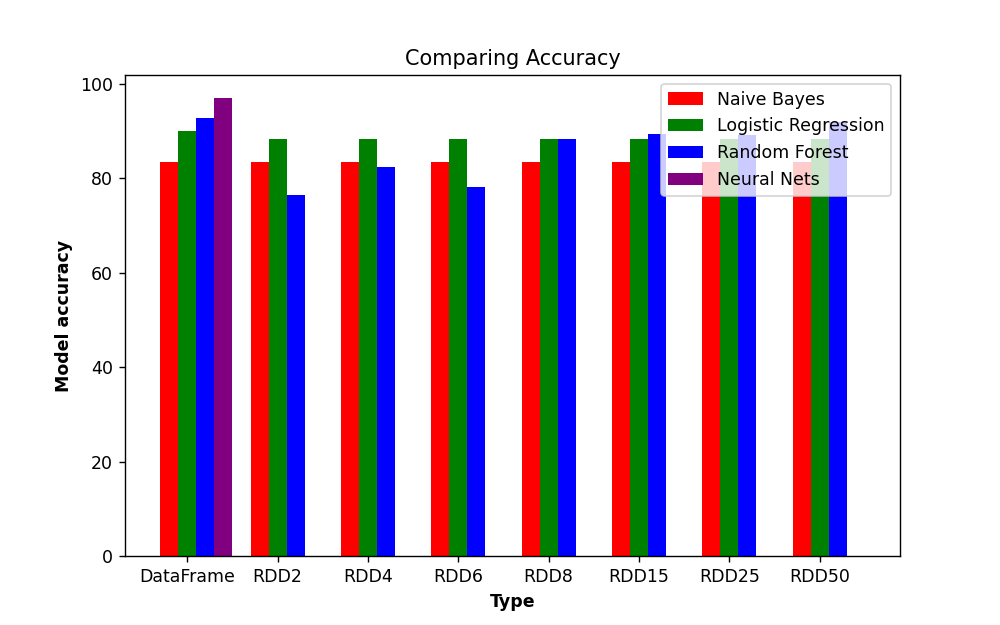

In [68]:
naivb_acc = [acc_nb_bestm*100, acc0, acc1, acc2, acc3, acc4, acc5, acc6]
lrmodel_acc = [lr_accuracy_bestm*100, lr_acc0, lr_acc1, lr_acc2, lr_acc3, lr_acc4, lr_acc5, lr_acc6]
randomfmodel_acc = [acc_rf_bestm*100, rf_acc0, rf_acc1, rf_acc2, rf_acc3, rf_acc4, rf_acc5, rf_acc6]
multineural_acc = [mlp_acc_bestm*100, 0, 0, 0, 0, 0, 0, 0]

data1 = [naivb_acc, lrmodel_acc, randomfmodel_acc, multineural_acc]
plot_bar(data1, 'Type', 'Model accuracy', 'Comparing Accuracy')

#### Time comparison

<IPython.core.display.Javascript object>


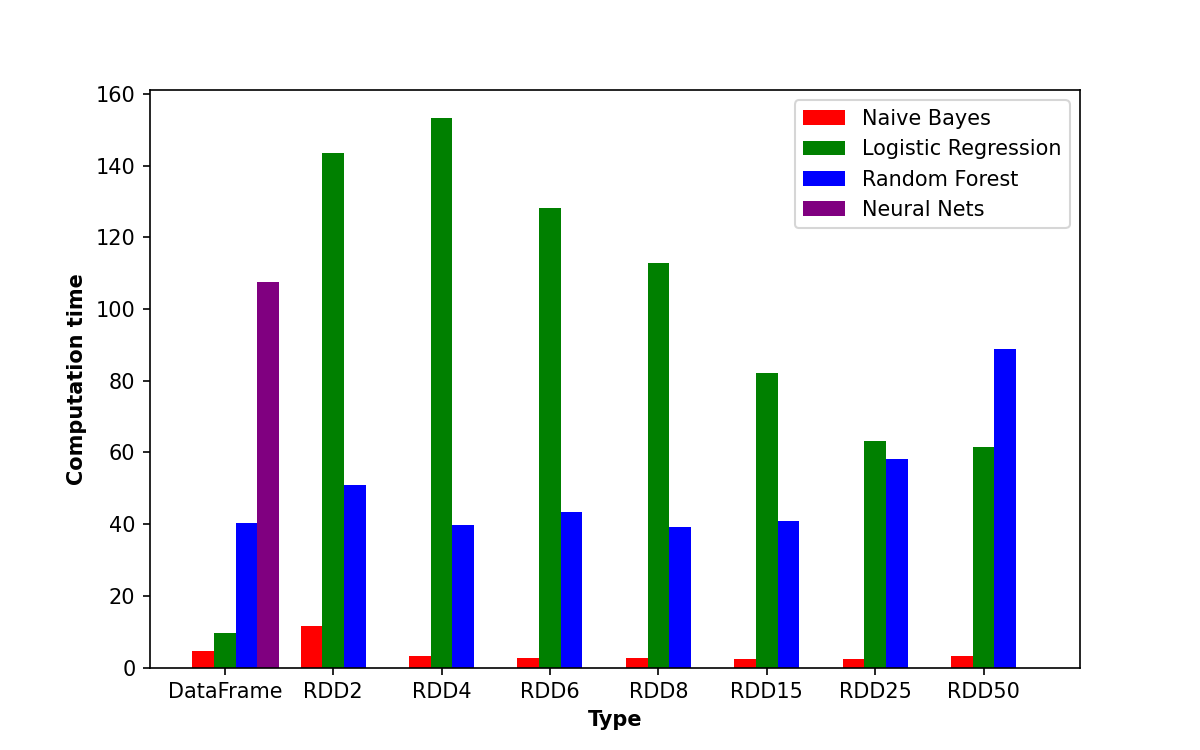

In [65]:
naiveb_t = [naiveb_time_bestm, time0, time1, time2, time3, time4, time5, time6]
lr_t = [logistic_time_bestm, lr_time0, lr_time1, lr_time2, lr_time3, lr_time4, lr_time5, lr_time6]
rf_t = [rf_time_bestm, rf_time0, rf_time1, rf_time2, rf_time3, rf_time4, rf_time5, rf_time6]
mlp_t = [mlp_time_bestm, 0, 0, 0, 0, 0, 0, 0]
data2 = [naiveb_t, lr_t, rf_t, mlp_t]
plot_bar(data2, 'Type', 'Computation time')